<a href="https://colab.research.google.com/github/bhaveshwadhwani/Quora-Question-Pair-Similarity/blob/master/Quora_question_pair_similarity_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h1>3. Exploratory Data Analysis </h1>

In [0]:
!pip install distance

     |████████████████████████████████| 184kB 2.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


<h2> 3.1 Reading data and basic stats </h2>

In [0]:
!ls

drive  sample_data


In [0]:
df = pd.read_csv("drive/My Drive/Quora/train.csv",nrows = 100000)

print("Number of data points:",df.shape[0])

Number of data points: 100000


In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
id              100000 non-null int64
qid1            100000 non-null int64
qid2            100000 non-null int64
question1       100000 non-null object
question2       100000 non-null object
is_duplicate    100000 non-null int64
dtypes: int64(4), object(2)
memory usage: 4.6+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

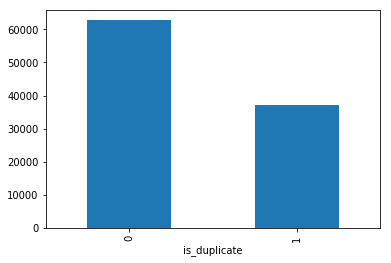

In [0]:
df.groupby("is_duplicate")['id'].count().plot.bar()



In [0]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   100000


In [0]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   62.75%

~> Question pairs are Similar (is_duplicate = 1):
   37.25%


<h3> 3.2.2 Number of unique questions </h3>

In [0]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 165931

Number of unique questions that appear more than one time: 19446 (11.719329118730075%)

Max number of times a single question is repeated: 32



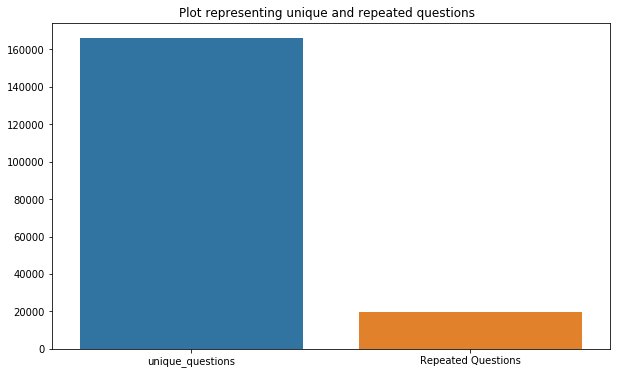

In [0]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [0]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 32



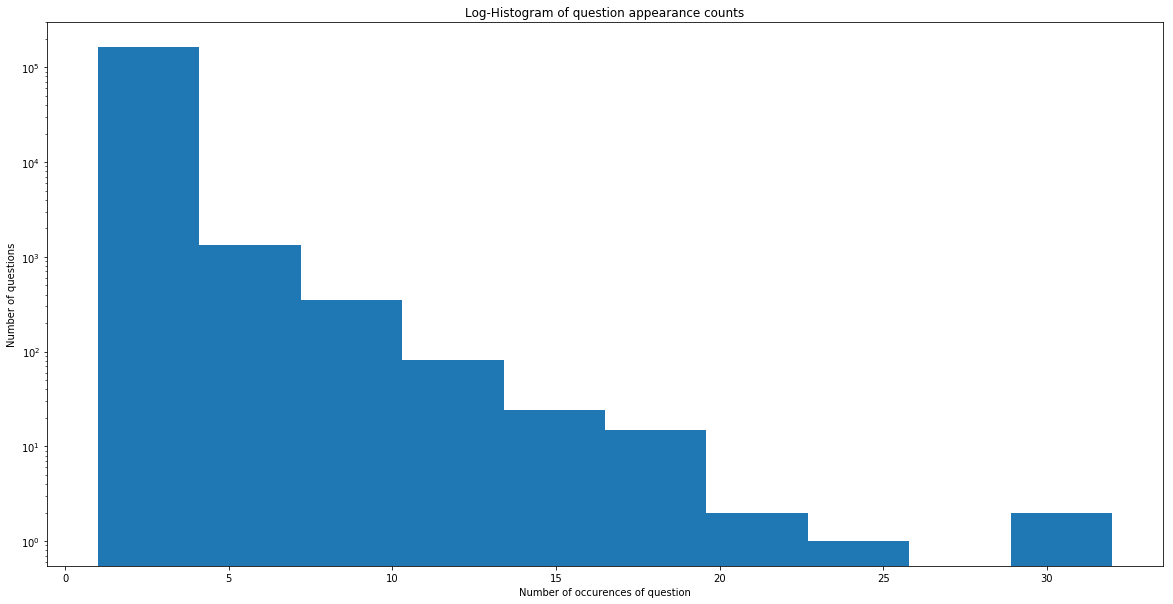

In [0]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=10)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [0]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


- There are no null values

In [0]:
# # Filling the null values with ' '
# df = df.fillna('')
# nan_rows = df[df.isnull().any(1)]
# print (nan_rows)

In [0]:
y_true = df['is_duplicate'].values
# df.drop(['is_duplicate'],axis=1,inplace = True)

In [0]:
df.shape

(100000, 6)

In [0]:
y_true.shape

(100000,)

In [0]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y_true, test_size=0.33, stratify=y_true)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [0]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in cross-val data :",X_cv.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (44890, 5)
Number of data points in cross-val data : (22110, 5)
Number of data points in test data : (33000, 5)


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

###  Basic Feature Extraction for train set

In [0]:
if os.path.isfile('drive/My Drive/Quora_assigment/X_train_fe_without_preprocessing.csv'):
    X_train = pd.read_csv("drive/My Drive/Quora_assigment/X_train_fe_without_preprocessing.csv",encoding='latin-1')
else:
    X_train['freq_qid1'] = X_train.groupby('qid1')['qid1'].transform('count') 
    X_train['freq_qid2'] = X_train.groupby('qid2')['qid2'].transform('count')
    X_train['q1len'] = X_train['question1'].str.len() 
    X_train['q2len'] = X_train['question2'].str.len()
    X_train['q1_n_words'] = X_train['question1'].apply(lambda row: len(row.split(" ")))
    X_train['q2_n_words'] = X_train['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    X_train['word_Common'] = X_train.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    X_train['word_Total'] = X_train.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    X_train['word_share'] = X_train.apply(normalized_word_share, axis=1)

    X_train['freq_q1+q2'] = X_train['freq_qid1']+X_train['freq_qid2']
    X_train['freq_q1-q2'] = abs(X_train['freq_qid1']-X_train['freq_qid2'])

    X_train.to_csv("drive/My Drive/Quora_assignment/X_train_fe_without_preprocessing_train.csv", index=False)

X_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
38970,38970,70704,70705,Can you suggest me a good name that is related...,What are the precautions to be taken for const...,0,1,1,73,69,15,12,0.0,27.0,0.000000,2,0
99681,99681,165453,165454,How do I know if I am a lesbian trapped in a m...,I am 15 and just came out to my dad as a lesbi...,0,1,1,83,118,19,30,5.0,39.0,0.128205,2,0
45433,45433,81424,81425,I'm not afraid of my future. What can I do?,I'm terribly afraid of my future. What should ...,0,1,1,43,51,10,10,8.0,20.0,0.400000,2,0
91049,91049,138056,152668,How much is one million and one billion in lak...,How do I spend one million dollar?,0,1,1,60,34,12,7,3.0,17.0,0.176471,2,0
82061,82061,139239,139240,Is there an advanced search syntax for Amazon'...,How was Amazon search in its initial stages?,0,1,1,53,44,9,8,1.0,17.0,0.058824,2,0


###  Basic Feature Extraction for cross set

In [0]:
if os.path.isfile('drive/My Drive/Quora_assigment/X_cv_fe_without_preprocessing.csv'):
    X_cv = pd.read_csv("drive/My Drive/Quora_assigment/X_cv_fe_without_preprocessing.csv",encoding='latin-1')
else:
    X_cv['freq_qid1'] = X_cv.groupby('qid1')['qid1'].transform('count') 
    X_cv['freq_qid2'] = X_cv.groupby('qid2')['qid2'].transform('count')
    X_cv['q1len'] = X_cv['question1'].str.len() 
    X_cv['q2len'] = X_cv['question2'].str.len()
    X_cv['q1_n_words'] = X_cv['question1'].apply(lambda row: len(row.split(" ")))
    X_cv['q2_n_words'] = X_cv['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    X_cv['word_Common'] = X_cv.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    X_cv['word_Total'] = X_cv.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    X_cv['word_share'] = X_cv.apply(normalized_word_share, axis=1)

    X_cv['freq_q1+q2'] = X_cv['freq_qid1']+X_cv['freq_qid2']
    X_cv['freq_q1-q2'] = abs(X_cv['freq_qid1']-X_cv['freq_qid2'])

    X_cv.to_csv("drive/My Drive/Quora_assignment/X_cv_fe_without_preprocessing.csv", index=False)

X_cv.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
60746,60746,106185,106186,What are some of the innovative startups in In...,What are some of the new innovative startups i...,0,1,1,50,54,9,10,9.0,19.0,0.473684,2,0
36802,36802,67067,67068,What are the tips and hacks for getting the cl...,What are the tips and hacks for getting the cl...,0,1,1,97,94,19,19,17.0,36.0,0.472222,2,0
78720,78720,134178,134179,Is it grammatically correct to put a comma aft...,What is relation between kp and kc?,0,1,1,71,35,11,7,1.0,17.0,0.058824,2,0
83051,83051,140697,140698,What is intermittent fasting?,What was your intermittent fasting experience?,0,1,1,29,46,4,6,2.0,10.0,0.200000,2,0
60336,60336,105528,105529,Why do black people have white palms?,"Why do so many Asian people say ""whites"" or ""b...",0,1,1,37,84,7,15,3.0,21.0,0.142857,2,0


###  Basic Feature Extraction for test set

In [0]:
if os.path.isfile('drive/My Drive/Quora_assigment/X_test_fe_without_preprocessing.csv'):
    X_test = pd.read_csv("drive/My Drive/Quora_assigment/X_test_fe_without_preprocessing.csv",encoding='latin-1')
else:
    X_test['freq_qid1'] = X_test.groupby('qid1')['qid1'].transform('count') 
    X_test['freq_qid2'] = X_test.groupby('qid2')['qid2'].transform('count')
    X_test['q1len'] = X_test['question1'].str.len() 
    X_test['q2len'] = X_test['question2'].str.len()
    X_test['q1_n_words'] = X_test['question1'].apply(lambda row: len(row.split(" ")))
    X_test['q2_n_words'] = X_test['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    X_test['word_Common'] = X_test.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    X_test['word_Total'] = X_test.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    X_test['word_share'] = X_test.apply(normalized_word_share, axis=1)

    X_test['freq_q1+q2'] = X_test['freq_qid1']+X_test['freq_qid2']
    X_test['freq_q1-q2'] = abs(X_test['freq_qid1']-X_test['freq_qid2'])

    X_test.to_csv("drive/My Drive/Quora_assignment/X_test_fe_without_preprocessing_train.csv", index=False)

X_test.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
13403,13403,25742,20236,Smartphones: What is the best phone camera at ...,Which phone has the best camera?,1,1,2,57,32,10,6,3.0,15.0,0.200000,3,1
21490,21490,40457,16040,Is the agricultural sector a failing one in In...,What are the problems in the agricultural sect...,1,1,1,50,58,9,10,5.0,18.0,0.277778,2,0
34199,34199,62703,62704,"When bacteria die do they also decay, will the...",Do bacteria reason in a very simplified way or...,0,1,1,80,108,14,19,4.0,31.0,0.129032,2,0
34671,34671,63487,63488,How can you identify a phishing attack and how...,How can I identify phishing Emails?,1,1,1,81,35,15,6,4.0,16.0,0.250000,2,0
75567,75567,19868,129309,Can using birth control cause complications in...,Can birth control pills cause me to become per...,1,1,1,66,65,9,10,4.0,19.0,0.210526,2,0


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [0]:
print ("Minimum length of the questions in question1 : " , min(X_train['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(X_train['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", X_train[X_train['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", X_train[X_train['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 6
Number of Questions with minimum length [question2] : 3


In [0]:
print ("Minimum length of the questions in question1 : " , min(X_cv['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(X_cv['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", X_cv[X_cv['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", X_cv[X_cv['q2_n_words']== 2].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  2
Number of Questions with minimum length [question1] : 6
Number of Questions with minimum length [question2] : 4


In [0]:
print ("Minimum length of the questions in question1 : " , min(X_test['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(X_test['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", X_test[X_test['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", X_test[X_test['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 3
Number of Questions with minimum length [question2] : 2


<h4> 3.3.1.1 Feature: word_share </h4>

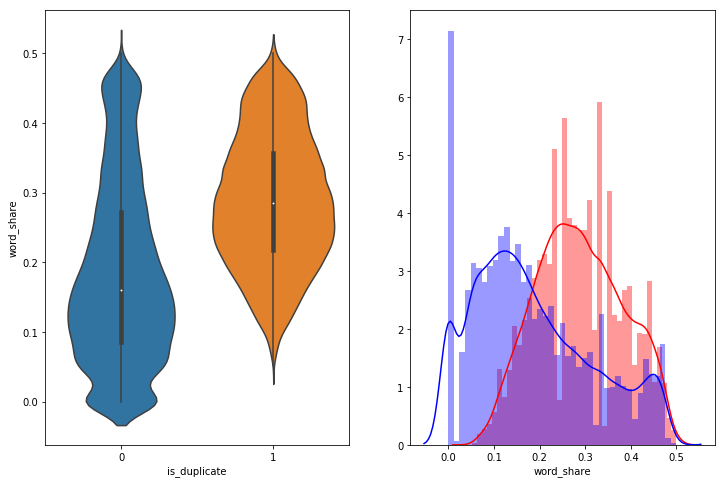

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = X_train)

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

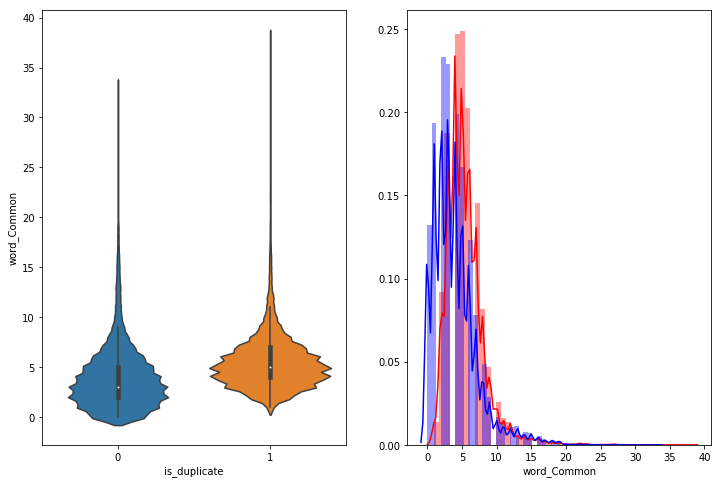

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = X_train)

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

### 3.3.5 : EDA: Advanced Feature Extraction.


In [0]:
!pip install fuzzywuzzy

In [0]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [0]:
# #https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
# if os.path.isfile('drive/My Drive/Quora_assignment/df_fe_without_preprocessing_train.csv'):
#     df = pd.read_csv("drive/My Drive/Quora_assignment/df_fe_without_preprocessing_train.csv",encoding='latin-1')
#     df = df.fillna('')
#     df.head()
# else:
#     print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [0]:
# df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0


### <h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [0]:
import nltk
nltk.download('stopwords')
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

### <h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word
-

Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [0]:
if os.path.isfile('drive/My Drive/Quora_assignment/nlp_features_train.csv'):
    X_train= pd.read_csv("drive/My Drive/Quora_assignment/nlp_features_train.csv",encoding='latin-1')
    X_train.fillna('')
else:
    print("Extracting features for train:")
#     df = pd.read_csv("drive/My Drive/Quora_assignment/train.csv")
    X_train= extract_features(X_train)
    X_train.to_csv("drive/My Drive/Quora_assignment/nlp_features_train.csv", index=False)
X_train.head(2)

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
38970,38970,70704,70705,can you suggest me a good name that is related...,what are the precautions to be taken for const...,0,1,1,73,69,15,12,0.0,27.0,0.000000,2,0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,4.0,14.0,36,36,36,43,0.057143
99681,99681,165453,165454,how do i know if i am a lesbian trapped in a m...,i am 15 and just came out to my dad as a lesbi...,0,1,1,83,118,19,30,5.0,39.0,0.128205,2,0,0.142855,0.142855,0.454541,0.35714,0.299999,0.199999,0.0,0.0,10.0,25.0,43,49,35,42,0.127907


In [0]:
if os.path.isfile('drive/My Drive/Quora_assignment/nlp_features_cv.csv'):
    X_cv= pd.read_csv("drive/My Drive/Quora_assignment/nlp_features_cv.csv",encoding='latin-1')
    X_cv.fillna('')
else:
    print("Extracting features for cv:")
#     df = pd.read_csv("drive/My Drive/Quora_assignment/cv.csv")
    X_cv= extract_features(X_cv)
    X_cv.to_csv("drive/My Drive/Quora_assignment/nlp_features_cv.csv", index=False)
X_cv.head(2)

Extracting features for cv:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
60746,60746,106185,106186,what are some of the innovative startups in in...,what are some of the new innovative startups i...,0,1,1,50,54,9,10,9.0,19.0,0.473684,2,0,0.999967,0.749981,0.999983,0.999983,0.999989,0.899991,1.0,1.0,1.0,9.5,100,96,96,92,0.588235
36802,36802,67067,67068,what are the tips and hacks for getting the cl...,what are the tips and hacks for getting the cl...,0,1,1,97,94,19,19,17.0,36.0,0.472222,2,0,0.874989,0.874989,0.999990,0.999990,0.894732,0.894732,1.0,1.0,0.0,19.0,97,95,95,94,0.873684


In [0]:
if os.path.isfile('drive/My Drive/Quora_assignment/nlp_features_test.csv'):
    X_test= pd.read_csv("drive/My Drive/Quora_assignment/nlp_features_test.csv",encoding='latin-1')
    X_test.fillna('')
else:
    print("Extracting features for test:")
#     df = pd.read_csv("drive/My Drive/Quora_assignment/test.csv")
    X_test= extract_features(X_test)
    X_test.to_csv("drive/My Drive/Quora_assignment/nlp_features_test.csv", index=False)
X_test.head(2)

Extracting features for test:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
13403,13403,25742,20236,smartphones what is the best phone camera at ...,which phone has the best camera,1,1,2,57,32,10,6,3.0,15.0,0.200000,3,1,0.999967,0.599988,0.333322,0.249994,0.666656,0.399996,0,0,4,8.0,81,60,57,66,0.333333
21490,21490,40457,16040,is the agricultural sector a failing one in in...,what are the problems in the agricultural sect...,1,1,1,50,58,9,10,5.0,18.0,0.277778,2,0,0.749981,0.599988,0.499988,0.399992,0.555549,0.499995,1,0,1,9.5,79,68,62,79,0.490196


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [0]:
X_train_duplicate = X_train[X_train['is_duplicate'] == 1]
X_train_nonduplicate = X_train[X_train['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([X_train_duplicate["question1"], X_train_duplicate["question2"]]).flatten()
n = np.dstack([X_train_nonduplicate["question1"], X_train_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('drive/My Drive/Quora_assignment/train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('drive/My Drive/Quora_assignment/train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 33446
Number of data points in class 0 (non duplicate pairs) : 56334


In [0]:
X_cv_duplicate = X_cv[X_cv['is_duplicate'] == 1]
X_cv_nonduplicate = X_cv[X_cv['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([X_cv_duplicate["question1"], X_cv_duplicate["question2"]]).flatten()
n = np.dstack([X_cv_nonduplicate["question1"], X_cv_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('drive/My Drive/Quora_assignment/cv_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('drive/My Drive/Quora_assignment/cv_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 16474
Number of data points in class 0 (non duplicate pairs) : 27746


In [0]:
X_test_duplicate = X_test[X_test['is_duplicate'] == 1]
X_test_nonduplicate = X_test[X_test['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([X_test_duplicate["question1"], X_test_duplicate["question2"]]).flatten()
n = np.dstack([X_test_nonduplicate["question1"], X_test_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('drive/My Drive/Quora_assignment/test_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('drive/My Drive/Quora_assignment/test_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 24588
Number of data points in class 0 (non duplicate pairs) : 41412


In [0]:
# reading the text files and removing the Stop Words:
d = 'drive/My Drive/Quora_assignment/'

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 1804520
Total number of words in non duplicate pair questions : 3663966


In [0]:
# reading the text files and removing the Stop Words:
d = 'drive/My Drive/Quora_assignment/'

textp_w_cv = open(path.join(d, 'cv_p.txt')).read()
textn_w_cv = open(path.join(d, 'cv_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w_cv))
print ("Total number of words in non duplicate pair questions :",len(textn_w_cv))

Total number of words in duplicate pair questions : 884086
Total number of words in non duplicate pair questions : 1804102


In [0]:
# reading the text files and removing the Stop Words:
d = 'drive/My Drive/Quora_assignment/'

textp_w_test = open(path.join(d, 'test_p.txt')).read()
textn_w_test = open(path.join(d, 'test_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w_test))
print ("Total number of words in non duplicate pair questions :",len(textn_w_test))

Total number of words in duplicate pair questions : 1333031
Total number of words in non duplicate pair questions : 2681939


### WordCloud  For Train Set

__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


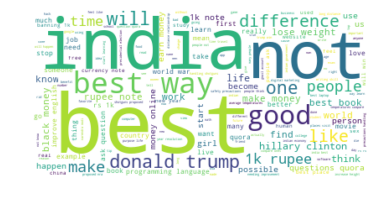

In [0]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


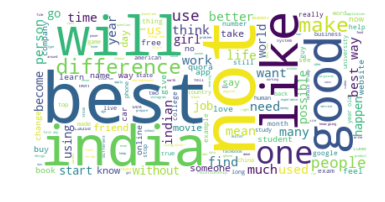

In [0]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### WordCloud  For CV Set

Word Cloud for Duplicate Question pairs


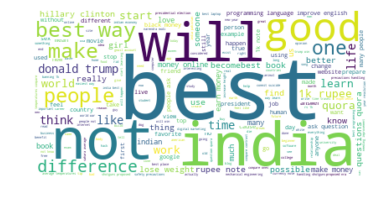

In [0]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w_cv)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


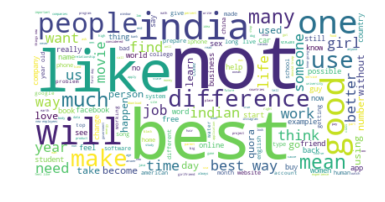

In [0]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w_cv)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### WordCloud  For Test Set

Word Cloud for Duplicate Question pairs


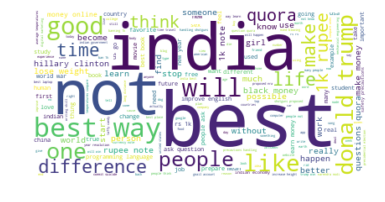

In [0]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w_test)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


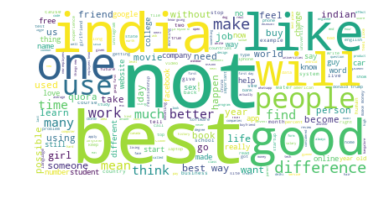

In [0]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w_test)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

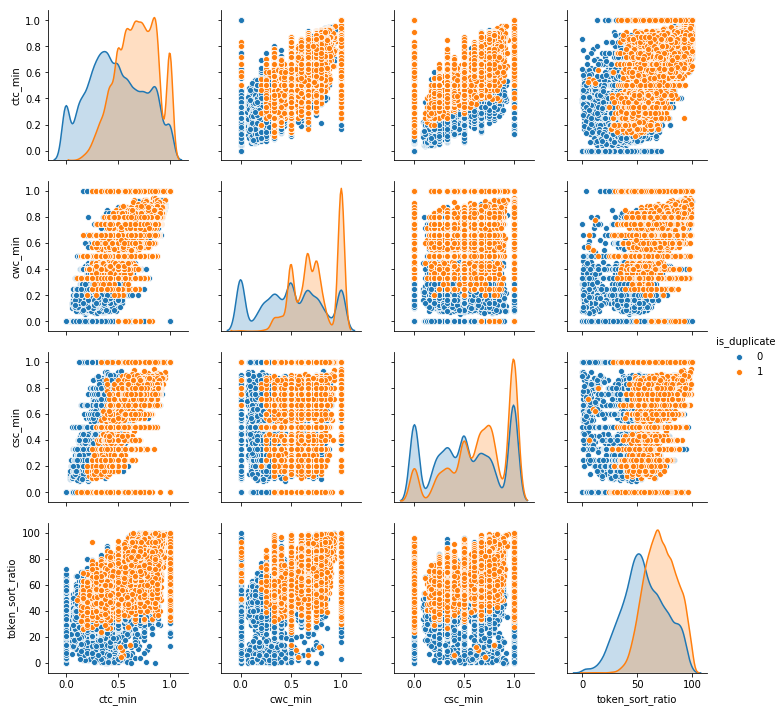

In [0]:
n = X_train.shape[0]
sns.pairplot(X_train[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

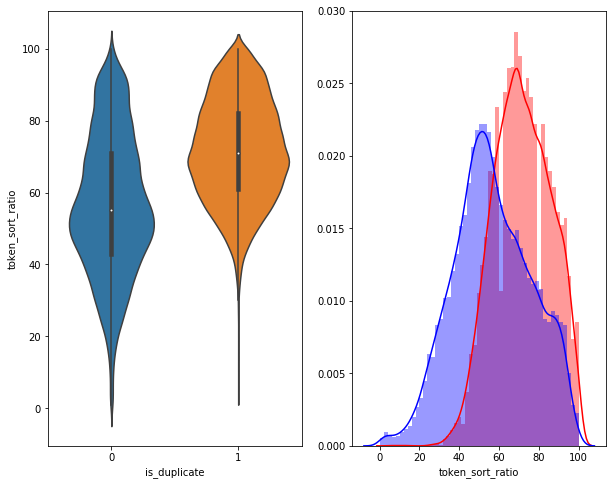

In [0]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = X_train[0:] , )

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

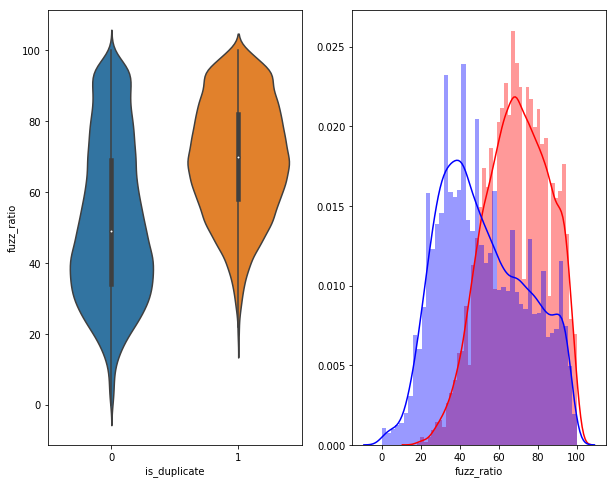

In [0]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = X_train[0:] , )

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [0]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

X_trainp_subsampled = X_train[0:5000]
X = MinMaxScaler().fit_transform(X_trainp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = X_trainp_subsampled['is_duplicate'].values

In [0]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.025s...
[t-SNE] Computed neighbors for 5000 samples in 0.438s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.138864
[t-SNE] Computed conditional probabilities in 0.306s
[t-SNE] Iteration 50: error = 80.9635162, gradient norm = 0.0418726 (50 iterations in 2.776s)
[t-SNE] Iteration 100: error = 70.6095810, gradient norm = 0.0121856 (50 iterations in 1.885s)
[t-SNE] Iteration 150: error = 68.8774948, gradient norm = 0.0057241 (50 iterations in 1.751s)
[t-SNE] Iteration 200: error = 68.1385345, gradient norm = 0.0037310 (50 iterations in 1.779s)
[t-SNE] Iteration 250: error = 67.7121658, gradient norm = 0.0037579

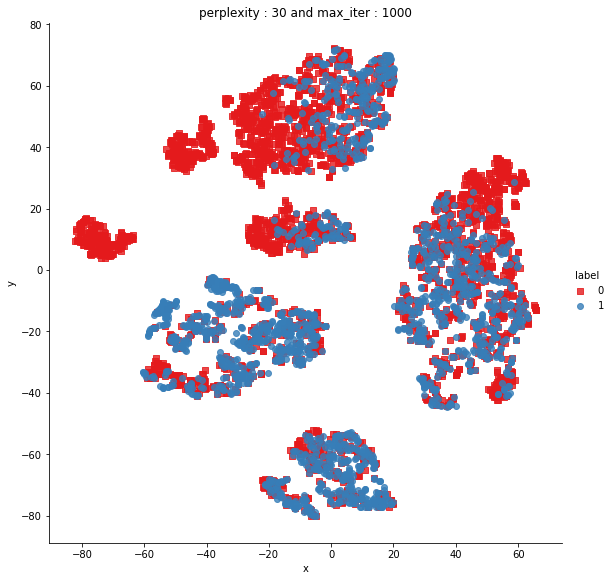

In [0]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [0]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.019s...
[t-SNE] Computed neighbors for 5000 samples in 0.437s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.138864
[t-SNE] Computed conditional probabilities in 0.292s
[t-SNE] Iteration 50: error = 81.5270157, gradient norm = 0.0352745 (50 iterations in 11.530s)
[t-SNE] Iteration 100: error = 69.6421280, gradient norm = 0.0034818 (50 iterations in 6.108s)
[t-SNE] Iteration 150: error = 68.3586655, gradient norm = 0.0017799 (50 iterations in 5.151s)
[t-SNE] Iteration 200: error = 67.7689056, gradient norm = 0.0011547 (50 iterations in 5.504s)
[t-SNE] Iteration 250: error = 67.4351501, gradient norm = 0.000944

In [0]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [0]:
# # avoid decoding problems
# df = pd.read_csv("drive/My Drive/Quora/train.csv",nrows=10000)
# y_true = data['is_duplicate'].values
# df.drop(['is_duplicate'], axis=1, inplace=True)

# X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

# print("Number of data points in train data :",X_train.shape)
# print("Number of data points in test data :",X_test.shape)


In [0]:
# # encode questions to unicode
# # https://stackoverflow.com/a/6812069
# # ----------------- python 2 ---------------------
# # df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# # df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# # ----------------- python 3 ---------------------
# df['question1'] = df['question1'].apply(lambda x: str(x))
# df['question2'] = df['question2'].apply(lambda x: str(x))

In [0]:
!ls

sample_data


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
# word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

<808580x109679 sparse matrix of type '<class 'numpy.float64'>'
	with 8146555 stored elements in Compressed Sparse Row format>

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)


# questions_train = list(X_train['question1']) + list(X_train['question2'])
# questions_cv = list(X_cv['question1']) + list(X_cv['question2'])
# questions_test = list(X_test['question1']) + list(X_test['question2'])

tfidf_train_q1 =  vectorizer.fit_transform(X_train['question1'].values)
tfidf_cv_q1    =  vectorizer.transform(X_cv['question1'].values)
tfidf_test_q1  =  vectorizer.transform(X_test['question1'].values)

feat_tfidf = vectorizer.get_feature_names()
print("Train tfidf ",tfidf_train_q1.shape)
print("CV tfidf",tfidf_cv_q1.shape)
print("Test tfidf",tfidf_test_q1.shape)

Train tfidf  (44890, 5000)
CV tfidf (22110, 5000)
Test tfidf (33000, 5000)


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)


# questions_train = list(X_train['question1']) + list(X_train['question2'])
# questions_cv = list(X_cv['question1']) + list(X_cv['question2'])
# questions_test = list(X_test['question1']) + list(X_test['question2'])

tfidf_train_q2 =  vectorizer.fit_transform(X_train['question2'].values)
tfidf_cv_q2    =  vectorizer.transform(X_cv['question2'].values)
tfidf_test_q2  =  vectorizer.transform(X_test['question2'].values)

feat_tfidf_q2 = vectorizer.get_feature_names()
print("Train tfidf ",tfidf_train_q2.shape)
print("CV tfidf",tfidf_cv_q2.shape)
print("Test tfidf",tfidf_test_q2.shape)

Train tfidf  (44890, 5000)
CV tfidf (22110, 5000)
Test tfidf (33000, 5000)


In [0]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [2:13:51<00:00, 50.34it/s]


In [0]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec1 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:47:52<00:00, 62.46it/s]


In [0]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [0]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [0]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [0]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [0]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,121.929927,100.083900,72.497894,115.641800,-48.370870,34.619058,-172.057787,-92.502617,113.223315,50.562441,...,12.397642,40.909519,8.150261,-15.170692,18.007709,6.166999,-30.124163,3.700902,-1.757693,-1.818058
1,-78.070939,54.843781,82.738482,98.191872,-51.234859,55.013510,-39.140730,-82.692352,45.161489,-9.556289,...,-21.987077,-12.389279,20.667979,2.202714,-17.142454,-5.880972,-10.123963,-4.890663,-13.018389,-5.219310
2,-5.355015,73.671810,14.376365,104.130241,1.433537,35.229116,-148.519385,-97.124595,41.972195,50.948731,...,3.027700,14.025767,-2.960312,-3.206544,4.355141,2.936152,-20.199555,9.816351,11.894366,-8.798819
3,5.778359,-34.712038,48.999631,59.699204,40.661263,-41.658731,-36.808594,24.170655,0.235600,-29.407290,...,13.100007,1.405670,-1.891076,-7.882638,18.000561,12.106918,-10.507835,5.243834,10.158340,5.886351
4,51.138220,38.587312,123.639488,53.333041,-47.062739,37.356212,-298.722753,-106.421119,106.248914,65.880707,...,13.906532,43.461721,11.519207,-22.468284,45.431128,8.161224,-35.373910,7.728865,9.592849,5.447336


In [0]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,125.983301,95.636485,42.114702,95.449980,-37.386295,39.400078,-148.116070,-87.851475,110.371966,62.272814,...,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,-106.871904,80.290331,79.066297,59.302092,-42.175328,117.616655,-144.364237,-127.131513,22.962533,25.397575,...,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,7.072875,15.513378,1.846914,85.937583,-33.808811,94.702337,-122.256856,-114.009530,53.922293,60.131814,...,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,39.421531,44.136989,-24.010929,85.265863,-0.339022,-9.323137,-60.499651,-37.044763,49.407848,-23.350150,...,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,31.950101,62.854106,1.778164,36.218768,-45.130875,66.674880,-106.342341,-22.901008,59.835938,62.663961,...,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689


In [0]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 384
Number of features in question2 w2v  dataframe : 384
Number of features in final dataframe  : 794


In [0]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [0]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [0]:
#Creating db file from csv
if not os.path.isfile('drive/My Drive/Quora/train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [0]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [0]:
read_db = 'drive/My Drive/Quora/train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [0]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        data =pd.read_sql_query("""SELECT * From data ORDER BY RANDOM() LIMIT 100001;""", conn_r)
        
        # for selecting random points
#         data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [0]:
data.shape

(100001, 798)

In [0]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate'].values
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [0]:
data.shape


(100000, 794)

In [0]:
y_true.shape


(100000,)

In [0]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.599988000239995,0.374995312558593,0.66664444518516,0.399992000159997,0.624992187597655,0.384612426058261,0.0,1.0,5.0,10.5,74,62,59,71,0.325581395348837,1,3,82,42,13,8,5.0,21.0,0.238095238095238,4,2,57.1058412827551,10.6745837330818,23.2628687694669,-33.6145638562739,33.9563886523247,-54.3863698244095,-38.9512281417847,-5.65749143064022,19.4633273463696,-14.4108464121819,0.413780856877565,-90.0927007198334,-25.9417567253113,39.9195522069931,...,-1.12130831182003,-6.98040819168091,-6.33985570073128,7.6240513920784,22.3642468806356,-6.40829902887344,-5.13831973075867,5.59842221438885,-2.4262265637517,5.13488824665546,4.47589510679245,9.35799412429333,-1.54873855412006,-18.6881028264761,-0.318126812577248,-27.2441799640656,-12.7842939198017,3.23777961730957,10.4648281931877,3.1136802136898,-16.1753657013178,-6.6811613291502,8.9008380137384,-8.09360283613205,10.669078797102,13.805245757103,-3.37707404792309,11.9117770791054,-13.6444728076458,-9.17912252247334,-4.08385995030403,14.0245571732521,5.93214458227158,-6.84712482988834,9.7337102573365,2.93709091842175,-8.35303891450167,3.64266863837838,-2.83494944870472,0.795595072209835
2,0.0,0.0,0.33332222259258,0.199996000079998,0.14285510206997,0.111109876556927,0.0,0.0,2.0,8.0,47,47,34,42,0.21875,1,2,47,31,9,7,1.0,16.0,0.0625,3,1,8.77402806282043,26.4920916557312,-25.6423462629318,151.584264576435,-12.4909554719925,10.1954989433289,-80.1942399442196,-8.31146311759949,10.3102250099182,65.4081729203463,23.3336698561907,-45.3783755302429,54.6424433588982,-33.0326794981956,...,-17.9594589471817,3.58886796236038,-6.29027318954468,5.16409941017628,20.1258146762848,-6.72773689031601,-6.86605572700501,9.4583829343319,-5.7872397005558,5.50593328475952,-0.359634578227997,-3.37525436282158,2.41916358470917,-9.87290219590068,0.113897413015366,-18.8911101222038,-10.9363823086023,16.1445648670197,7.70360687375069,9.39097859710455,-19.3960244655609,-9.99294281005859,-0.711765699088573,-11.8579163914546,9.96197581291199,4.71993850171566,-0.404253512620926,5.98044725437649,-18.5462153553963,-7.54864060878754,-6.00434684753418,2.09378188848496,-4.36162620782852,-2.86872500181198,9.95783281326294,3.96753732697107,-6.04816972836852,13.1370285153389,-4.59646981954575,-2.10167560027912
3,0.571420408279882,0.39999600004,0.249993750156246,0.124998437519531,0.416663194473379,0.277776234576475,0.0,0.0,6.0,15.0,63,55,50,59,0.193548387096774,18,1,92,61,18,12,5.0,29.0,0.172413793103448,19,17,111.379810988903,29.0309159681201,-17.0490934848785,163.781318992376,65.5736330747604,5.04822397232056,-123.368053853512,18.1942257136107,104.339100897312,65.868305683136,33.2836086694151,-76.4499957561493,80.5674305558205,-67.4319585561752,...,-16.6893599927425,4.52293415740132,-11.1851584911346,20.2472121715546,36.1004081815481,-3.33331942558289,-13.2763716876507,8.09458849206567,-17.5483088828623,3.25249992311001,5.05329053103924,-10.4370025992393,-11.4497925713658,-20.9479368925095,-17.451088488102,-36.9104922413826,-8.31025653332472,14.6365592330694,3.99670352041721,14.1713411808014,-31.4632322192192,-10.0113016366959,-0.462194621562958,-10.113861897029,27.8743404261768,23.7049300670624,-7.57172939367592,7.93385477364063,-14.4578313231468,-9.78929396728927,2.83521626889706,16.6881836429238,-3.64371617138386,-9.01050212979317,7.68894088082016,12.0409759283066,-15.9408362954855,18.9260811805725,7.33242186903953,7.84472468495369
4,0.49

<h2> 4.2 Converting strings to numerics </h2>

In [0]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
129_x
130_x
131_x
132_x
133_x
134_x
135_x
136

In [0]:
y_true[:10]

array(['1', '0', '0', '0', '0', '1', '0', '0', '0', '0'], dtype=object)

In [0]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = pd.Series(map(int,list(y_true)))

<h2> 4.3 Random train test split( 70:30) </h2>

In [0]:
# X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y_true, test_size=0.33, stratify=y_true)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [0]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_cv.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (44890, 794)
Number of data points in test data : (22110, 794)
Number of data points in test data : (33000, 794)


### For TFIDF data

In [0]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_cv.shape)
print("Number of data points in test data :",X_test.shape)


Number of data points in train data : (44890, 32)
Number of data points in test data : (22110, 32)
Number of data points in test data : (33000, 32)


In [0]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6274671419024281 Class 1:  0.37253285809757186
---------- Distribution of output variable in test data ----------
Class 0:  0.6274545454545455 Class 1:  0.37254545454545457


In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8900928865618952


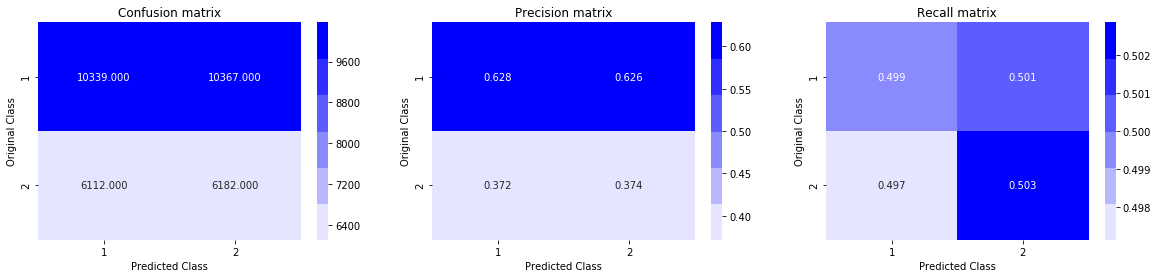

In [0]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.592800211149
For values of alpha =  0.0001 The log loss is: 0.532351700629
For values of alpha =  0.001 The log loss is: 0.527562275995
For values of alpha =  0.01 The log loss is: 0.534535408885
For values of alpha =  0.1 The log loss is: 0.525117052926
For values of alpha =  1 The log loss is: 0.520035530431
For values of alpha =  10 The log loss is: 0.521097925307


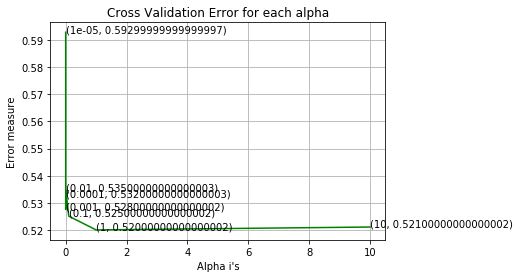

For values of best alpha =  1 The train log loss is: 0.513842874233
For values of best alpha =  1 The test log loss is: 0.520035530431
Total number of data points : 30000


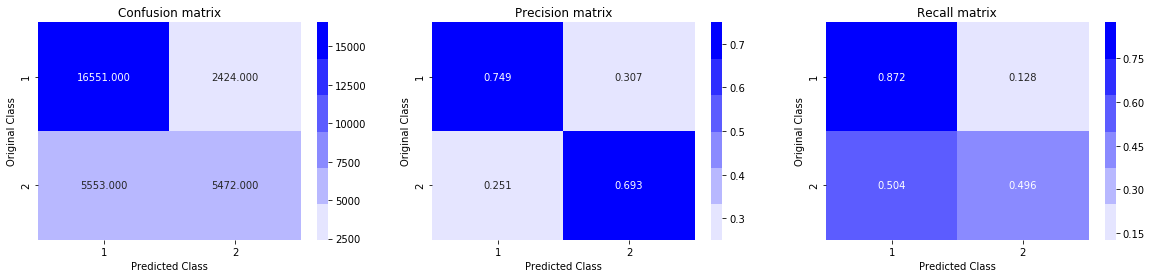

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state =None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.657611721261
For values of alpha =  0.0001 The log loss is: 0.489669093534
For values of alpha =  0.001 The log loss is: 0.521829068562
For values of alpha =  0.01 The log loss is: 0.566295616914
For values of alpha =  0.1 The log loss is: 0.599957866217
For values of alpha =  1 The log loss is: 0.635059427016
For values of alpha =  10 The log loss is: 0.654159467907


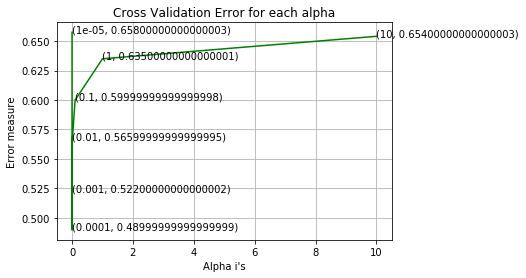

For values of best alpha =  0.0001 The train log loss is: 0.478054677285
For values of best alpha =  0.0001 The test log loss is: 0.489669093534
Total number of data points : 30000


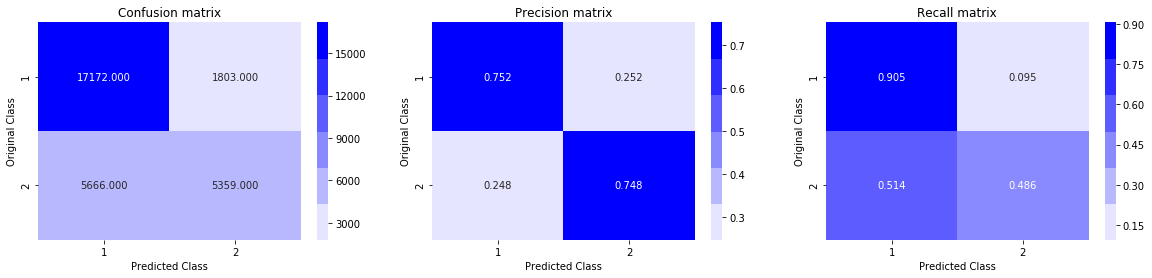

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### On Tfidf data

In [0]:
# 'cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2
cols = list(X_train.columns)

In [0]:
cols[5:]

['is_duplicate',
 'freq_qid1',
 'freq_qid2',
 'q1len',
 'q2len',
 'q1_n_words',
 'q2_n_words',
 'word_Common',
 'word_Total',
 'word_share',
 'freq_q1+q2',
 'freq_q1-q2',
 'cwc_min',
 'cwc_max',
 'csc_min',
 'csc_max',
 'ctc_min',
 'ctc_max',
 'last_word_eq',
 'first_word_eq',
 'abs_len_diff',
 'mean_len',
 'token_set_ratio',
 'token_sort_ratio',
 'fuzz_ratio',
 'fuzz_partial_ratio',
 'longest_substr_ratio']

In [0]:
X_train.shape


(44890, 32)

In [0]:
X_train[cols[6:]].shape

(44890, 26)

In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr = hstack((tfidf_train_q1,tfidf_train_q2,X_train[['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words','word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2','cwc_min','cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max','last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len','token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',  'fuzz_partial_ratio', 'longest_substr_ratio']])).tocsr()
X_cr = hstack((tfidf_cv_q1,tfidf_cv_q2,X_cv[['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words','word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2','cwc_min','cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max','last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len','token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',  'fuzz_partial_ratio', 'longest_substr_ratio']])).tocsr()
X_te = hstack((tfidf_test_q1,tfidf_test_q2,X_test[['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words','word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2','cwc_min','cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max','last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len','token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',  'fuzz_partial_ratio', 'longest_substr_ratio']])).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(44890, 10026) (44890,)
(22110, 10026) (22110,)
(33000, 10026) (33000,)


For values of alpha =  1e-05 The log loss is: 0.486122125885547
For values of alpha =  0.0001 The log loss is: 0.5331278421475841
For values of alpha =  0.001 The log loss is: 0.5478625643422692
For values of alpha =  0.01 The log loss is: 0.5246757351176663
For values of alpha =  0.1 The log loss is: 0.5677369451296661
For values of alpha =  1 The log loss is: 0.6136396550348843
For values of alpha =  10 The log loss is: 0.6602970012154868


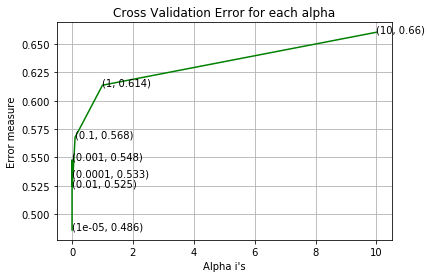

For values of best alpha =  1e-05 The train log loss is: 0.5043990230156697
For values of best alpha =  1e-05 The test log loss is: 0.5045227813866615
Total number of data points : 33000


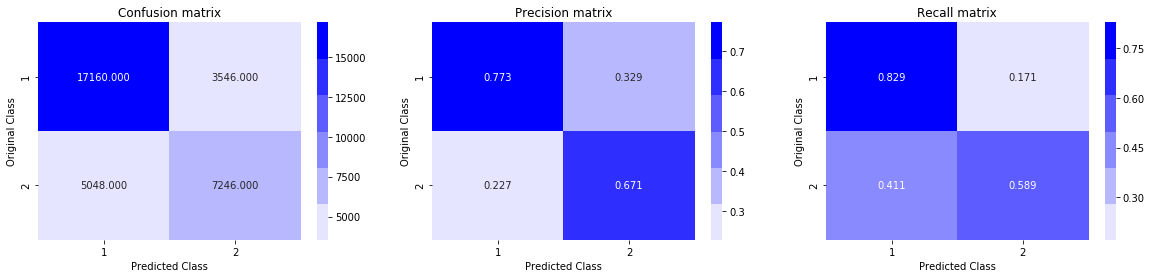

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state =None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='log', random_state=42)
    clf.fit(X_tr, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, y_train)
    predict_y = sig_clf.predict_proba(X_cr)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='log', random_state=42)
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_cr, y_cv)

predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.4789651965991101
For values of alpha =  0.0001 The log loss is: 0.4796432993221746
For values of alpha =  0.001 The log loss is: 0.49076128888211723
For values of alpha =  0.01 The log loss is: 0.5174224819637837
For values of alpha =  0.1 The log loss is: 0.5377837665263189
For values of alpha =  1 The log loss is: 0.5667679418881167
For values of alpha =  10 The log loss is: 0.5905260940044674


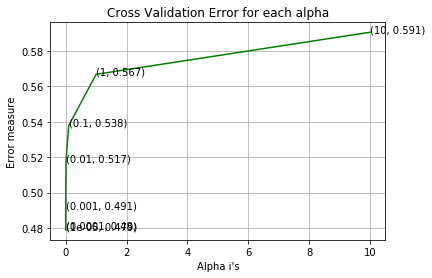

For values of best alpha =  1e-05 The train log loss is: 0.5026869940073284
For values of best alpha =  1e-05 The test log loss is: 0.5049064228811674
Total number of data points : 33000


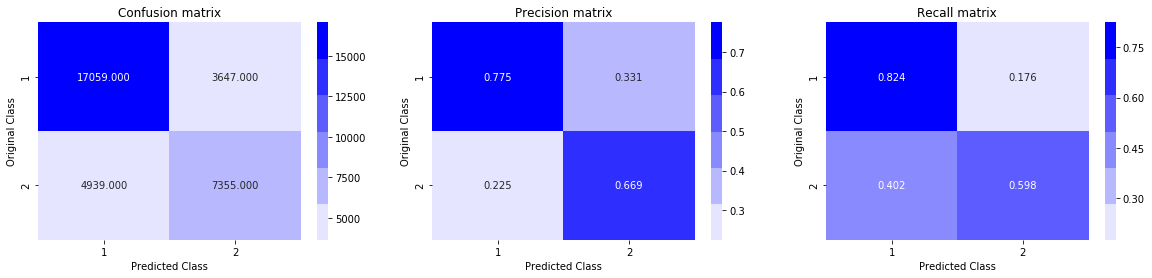

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state =None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_tr, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, y_train)
    predict_y = sig_clf.predict_proba(X_cr)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_cr, y_cv)

predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4848332825423125
For values of alpha =  0.0001 The log loss is: 0.5378475958582134
For values of alpha =  0.001 The log loss is: 0.5417904056869058
For values of alpha =  0.01 The log loss is: 0.5288605937385088
For values of alpha =  0.1 The log loss is: 0.5582942249037874
For values of alpha =  1 The log loss is: 0.6230572564022668
For values of alpha =  10 The log loss is: 0.6459682453560096


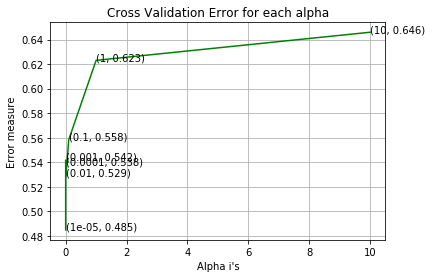

For values of best alpha =  1e-05 The train log loss is: 0.49829496672249113
For values of best alpha =  1e-05 The test log loss is: 0.49742513210493855
Total number of data points : 33000


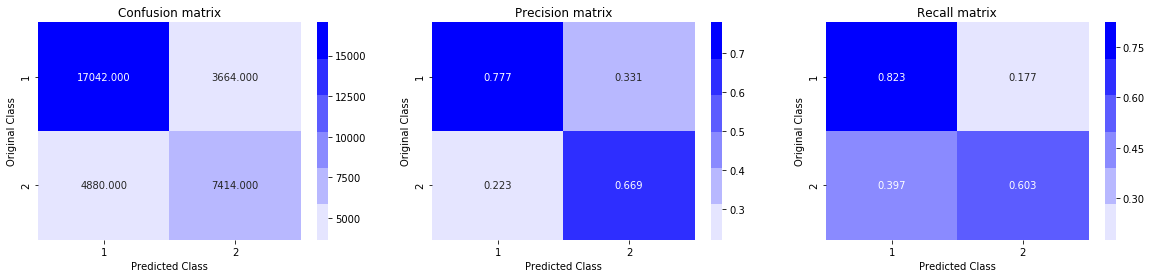

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_tr, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, y_train)
    predict_y = sig_clf.predict_proba(X_cr)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_cr, y_cv)

predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [0]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_tr, label=y_train)
d_test = xgb.DMatrix(X_cr , label=y_cv)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_tr,y_train)
d_test = xgb.DMatrix(X_te, label=y_test)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.686037	valid-logloss:0.686264
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.627941	valid-logloss:0.630236
[20]	train-logloss:0.585854	valid-logloss:0.58967
[30]	train-logloss:0.554472	valid-logloss:0.559685
[40]	train-logloss:0.530438	valid-logloss:0.536768
[50]	train-logloss:0.511657	valid-logloss:0.519057
[60]	train-logloss:0.496642	valid-logloss:0.504604
[70]	train-logloss:0.483971	valid-logloss:0.492629
[80]	train-logloss:0.473931	valid-logloss:0.48303
[90]	train-logloss:0.465607	valid-logloss:0.475318
[100]	train-logloss:0.45863	valid-logloss:0.468825
[110]	train-logloss:0.45258	valid-logloss:0.463205
[120]	train-logloss:0.447511	valid-logloss:0.458575
[130]	train-logloss:0.443278	valid-logloss:0.45462
[140]	train-logloss:0.439687	valid-logloss:0.451355
[150]	train-logloss:0.436489	valid-logloss:0.448471
[160]	train-logloss:0.433715	vali

Total number of data points : 33000


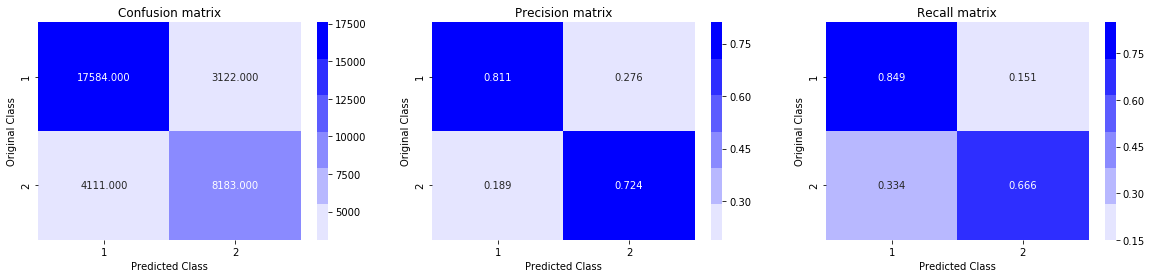

In [0]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [0]:
# https://gist.github.com/wrwr/3f6b66bf4ee01bf48be965f60d14454d
import time

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

x_train, y_train, x_valid, y_valid, x_test, y_test = X_tr , y_train , X_cr , y_cv , X_te , y_test  # load datasets

clf = xgb.XGBClassifier()

param_grid = {
        'silent': [False],
        'max_depth': [1,2,3,4,5],
        'learning_rate': [0.00001,0.0001,0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]}

fit_params = {'eval_metric': 'logloss',
              'early_stopping_rounds': 10,
              'eval_set': [(x_valid, y_valid)]}

rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,n_jobs=-1, verbose=2, cv=2,scoring='neg_log_loss', refit=False, random_state=42)
print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(x_train, y_train,**fit_params)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.8min


Randomized search time: 233.99588918685913
Best score: -0.3964163938054521
Best params: 
colsample_bylevel: 1.0
colsample_bytree: 0.7
gamma: 0.25
learning_rate: 0.2
max_depth: 4
min_child_weight: 5.0
n_estimators: 100
reg_lambda: 1.0
silent: False
subsample: 0.9


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.9min finished


In [0]:
import xgboost as xgb
params = {'objective' : 'binary:logistic', 
          'eval_metric' : 'logloss' , 
          'colsample_bylevel': 1.0 ,
          'colsample_bytree': 0.7,
          'gamma': 0.25 ,  
          'learning_rate': 0.2,
          'max_depth': 4,
          'min_child_weight': 5.0,
          'n_estimators': 100,
          'reg_lambda': 1.0,
          'silent': False,
          'subsample': 0.9}

d_train = xgb.DMatrix(X_tr, label=y_train)
d_test = xgb.DMatrix(X_cr , label=y_cv)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_tr,y_train)
d_test = xgb.DMatrix(X_te, label=y_test)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=np.array([0, 1]), eps=1e-15))

[0]	train-logloss:0.630701	valid-logloss:0.633702
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.450203	valid-logloss:0.461041
[20]	train-logloss:0.423017	valid-logloss:0.435876
[30]	train-logloss:0.409264	valid-logloss:0.424347
[40]	train-logloss:0.399364	valid-logloss:0.417086
[50]	train-logloss:0.392632	valid-logloss:0.412569
[60]	train-logloss:0.385623	valid-logloss:0.408459
[70]	train-logloss:0.380434	valid-logloss:0.40503
[80]	train-logloss:0.376415	valid-logloss:0.402892
[90]	train-logloss:0.372699	valid-logloss:0.400642
[100]	train-logloss:0.368354	valid-logloss:0.398424
[110]	train-logloss:0.365952	valid-logloss:0.397567
[120]	train-logloss:0.363346	valid-logloss:0.396579
[130]	train-logloss:0.359589	valid-logloss:0.395004
[140]	train-logloss:0.356627	valid-logloss:0.393626
[150]	train-logloss:0.353823	valid-logloss:0.392205
[160]	train-logloss:0.351752	

Total number of data points : 33000


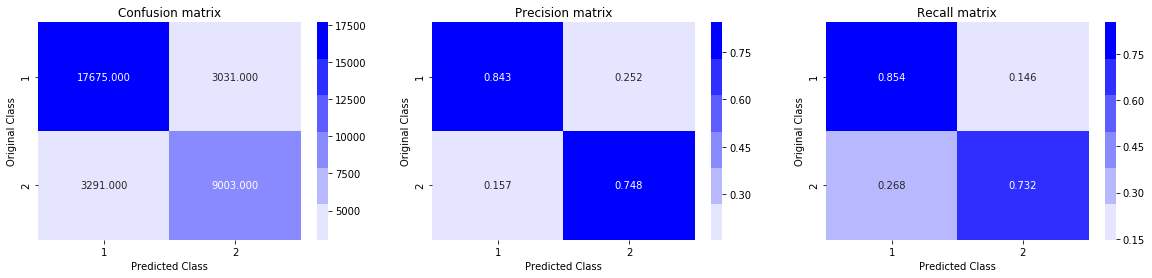

In [0]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### For TFIDF W2V data


In [0]:
# https://www.geeksforgeeks.org/understanding-python-pickling-example/
import pickle


# Its important to use binary mode 
pickle_file = open('drive/My Drive/Quora_assignment/Ass_Tfidf_W2V.pkl', 'wb') 

# source, destination 
pickle.dump(X_train, pickle_file)
pickle.dump(y_train, pickle_file)
pickle.dump(X_cv, pickle_file)
pickle.dump(y_cv, pickle_file)
pickle.dump(X_test, pickle_file)
pickle.dump(y_test, pickle_file)
pickle_file.close() 

In [0]:
import pickle
pickle_file = open('drive/My Drive/Quora_assignment/Ass_Tfidf_W2V.pkl', 'rb')      
X_train = pickle.load(pickle_file) 
y_train = pickle.load(pickle_file)
X_cv = pickle.load(pickle_file) 
y_cv = pickle.load(pickle_file)
X_test = pickle.load(pickle_file) 
y_test = pickle.load(pickle_file)
pickle_file.close()

In [0]:
print(X_train.shape,X_cv.shape,X_test.shape)

(44890, 794) (22110, 794) (33000, 794)


<h2> 4.6 XGBoost </h2>

In [0]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684819	valid-logloss:0.684845
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61583	valid-logloss:0.616104
[20]	train-logloss:0.564616	valid-logloss:0.565273
[30]	train-logloss:0.525758	valid-logloss:0.52679
[40]	train-logloss:0.496661	valid-logloss:0.498021
[50]	train-logloss:0.473563	valid-logloss:0.475182
[60]	train-logloss:0.455315	valid-logloss:0.457186
[70]	train-logloss:0.440442	valid-logloss:0.442482
[80]	train-logloss:0.428424	valid-logloss:0.430795
[90]	train-logloss:0.418803	valid-logloss:0.421447
[100]	train-logloss:0.41069	valid-logloss:0.413583
[110]	train-logloss:0.403831	valid-logloss:0.40693
[120]	train-logloss:0.398076	valid-logloss:0.401402
[130]	train-logloss:0.393305	valid-logloss:0.396851
[140]	train-logloss:0.38913	valid-logloss:0.392952
[150]	train-logloss:0.385469	valid-logloss:0.389521
[160]	train-logloss:0.382327	vali

Total number of data points : 30000


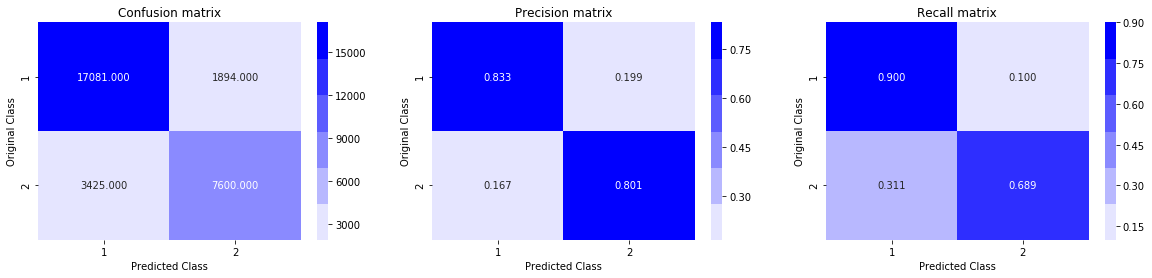

In [0]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [0]:
# https://gist.github.com/wrwr/3f6b66bf4ee01bf48be965f60d14454d
import time

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

x_train, y_train, x_valid, y_valid, x_test, y_test = X_train , y_train , X_cv , y_cv , X_test , y_test  # load datasets

clf = xgb.XGBClassifier()

param_grid = {
        'silent': [False],
        'max_depth': [1,2,3,4],
        'learning_rate': [0.00001,0.0001,0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]}

fit_params = {'eval_metric': 'logloss',
              'early_stopping_rounds': 10,
              'eval_set': [(x_valid, y_valid)]}

rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,n_jobs=-1, verbose=2, cv=2,scoring='neg_log_loss', refit=False, random_state=42)
print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(x_train, y_train,**fit_params)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 20.7min


Randomized search time: 1294.6718440055847
Best score: -0.37062025775996893
Best params: 
colsample_bylevel: 0.9
colsample_bytree: 0.5
gamma: 0
learning_rate: 0.2
max_depth: 2
min_child_weight: 0.5
n_estimators: 100
reg_lambda: 50.0
silent: False
subsample: 0.7


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 21.6min finished


In [0]:
import xgboost as xgb
from sklearn.metrics.classification import accuracy_score, log_loss

params = {'objective' : 'binary:logistic', 
          'eval_metric' : 'logloss' , 
          'colsample_bylevel': 0.9 ,
          'colsample_bytree': 0.5,
          'gamma': 0 ,  
          'learning_rate': 0.2,
          'max_depth': 2,
          'min_child_weight': 0.5,
          'n_estimators': 100,
          'reg_lambda': 50,
          'silent': False,
          'subsample': 0.7}


d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_cv , label=y_cv)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
d_test = xgb.DMatrix(X_test, label=y_test)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=np.array([0, 1]), eps=1e-15))

[0]	train-logloss:0.640877	valid-logloss:0.641782
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.461213	valid-logloss:0.462357
[20]	train-logloss:0.418264	valid-logloss:0.421439
[30]	train-logloss:0.402297	valid-logloss:0.406791
[40]	train-logloss:0.390498	valid-logloss:0.396445
[50]	train-logloss:0.380775	valid-logloss:0.387824
[60]	train-logloss:0.3734	valid-logloss:0.38167
[70]	train-logloss:0.368185	valid-logloss:0.377755
[80]	train-logloss:0.36413	valid-logloss:0.375146
[90]	train-logloss:0.360052	valid-logloss:0.372069
[100]	train-logloss:0.356098	valid-logloss:0.368832
[110]	train-logloss:0.353312	valid-logloss:0.367147
[120]	train-logloss:0.350631	valid-logloss:0.365369
[130]	train-logloss:0.348349	valid-logloss:0.363831
[140]	train-logloss:0.346149	valid-logloss:0.362506
[150]	train-logloss:0.34407	valid-logloss:0.361372
[160]	train-logloss:0.342202	vali

Total number of data points : 33000


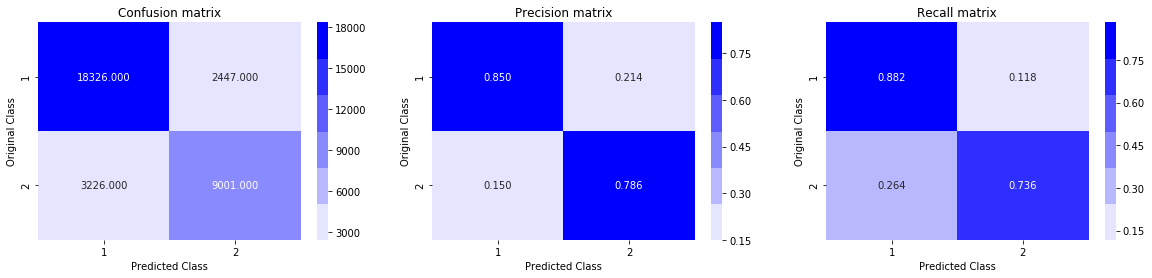

In [0]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 5. Conclusions

In [0]:
# Please compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]

x.add_row(["NA", "RANDOM", "NA", 0.89])
x.add_row(["TFIDF", "Linear SVM", "Alpha:10**-5 Penalty:L1", 0.497])
x.add_row(["TFIDF", "Logistic Regression", "Alpha:10**-5 Penalty:L1", 0.504])
x.add_row(["TFIDF", "Logistic Regression", "Alpha:10**-5 Penalty:L2", 0.505])
x.add_row(["TFIDF-weighted W2V", "Linear SVM", "Alpha:0.0001 Penalty:L1", 0.48])
x.add_row(["TFIDF-weighted W2V", "Logistic Regression", "Alpha:1 Penalty:L1", 0.52])
x.add_row(["TFIDF", "XGBoost", "Default Parameters", 0.41])
x.add_row(["TFIDF", "XGBoost", '''colsample_bylevel: 1.0,colsample_bytree: 0.7,gamma: 0.25,learning_rate: 0.2,max_depth: 4,
min_child_weight: 5.0,n_estimators: 100,reg_lambda: 1.0,silent: False,subsample: 0.9''', 0.378])
x.add_row(["TFIDF-weighted W2V", "XGBoost", "Default Parameters", 0.357])
x.add_row(["TFIDF-weighted W2V", "XGBoost", ''''colsample_bylevel': 0.9 ,'colsample_bytree': 0.5,'gamma': 0 ,'learning_rate': 0.2,
          'max_depth': 2,'min_child_weight': 0.5,'n_estimators': 100,'reg_lambda': 50,'silent': False,'subsample': 0.7''', 0.347])

print(x)

+--------------------+---------------------+------------------------------------------------------------------------------------------------------------------------+-------+
|     Vectorizer     |        Model        |                                                    Hyper Parameter                                                     |  AUC  |
+--------------------+---------------------+------------------------------------------------------------------------------------------------------------------------+-------+
|         NA         |        RANDOM       |                                                           NA                                                           |  0.89 |
|       TFIDF        |      Linear SVM     |                                                Alpha:10**-5 Penalty:L1                                                 | 0.497 |
|       TFIDF        | Logistic Regression |                                                Alpha:10**-5 Penalty:L1               

### Observations



1.   We have Random Model with log loss of 0.89
2.   We have tried modelling data for TFIDF and TFIDF weighted W2V data and tried with Logistic Regression , Linear SVM , XGBoost
3.   We have got good values for logistic regression with TFIDF as compared to weighted w2v models.
4.   We have got good values for Linear SVM with TFIDF  weighted w2v as compared to TFIDF  models.
5.   We have got good values for XGBOOST with TFIDF  weighted w2v as compared to TFIDF  models.
6.   After tuning XGBoost we got slight increase of performance and results of model .
